<a href="https://colab.research.google.com/github/ansh-dulewale/Mini-project-web/blob/main/PlasticTypeDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the Kaggle library
!pip install kaggle
!pip install kagglehub

# Upload your Kaggle API key
from google.colab import files
print("Please upload your kaggle.json file")
files.upload()

# Move the API key to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'type-of-plastic-waste-dataset' dataset.
Path to dataset files: /kaggle/input/type-of-plastic-waste-dataset


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# --- Function to analyze a dataset split (train or val) ---
def analyze_dataset_split(directory, split_name):
    """
    Analyzes a given directory (train or val) to summarize and visualize its contents.

    Args:
        directory (str): The path to the directory to analyze.
        split_name (str): The name of the split (e.g., "Training Set").

    Returns:
        pd.DataFrame: A dataframe containing the image counts per class.
    """
    print(f"\n{'='*20} Analysis of {split_name} {'='*20}")

    try:
        classes = sorted(os.listdir(directory))
        if not classes:
            print(f"No class folders found in '{directory}'. Please check the path.")
            return None

        image_counts = {cls: len(os.listdir(os.path.join(directory, cls))) for cls in classes}
        summary_df = pd.DataFrame(list(image_counts.items()), columns=['Plastic Type', 'Image Count'])

        # Display summary table
        print(f"\n--- {split_name} Summary ---")
        print(summary_df)
        print(f"Total Images in {split_name}: {summary_df['Image Count'].sum()}")

        # Visualize class distribution
        # plt.figure(figsize=(10, 5))
        # plt.bar(summary_df['Plastic Type'], summary_df['Image Count'], color='teal')
        # plt.title(f'Image Distribution in {split_name}')
        # plt.xlabel('Plastic Type')
        # plt.ylabel('Number of Images')
        # plt.xticks(rotation=45)
        # plt.show()

        return summary_df

    except FileNotFoundError:
        print(f"\nError: The directory was not found at the specified path:")
        print(f"'{directory}'")
        print("Please double-check the path and try again.")
        return None

# --- 1. Define the base path to your dataset splits ---
base_dir = "/kaggle/input/type-of-plastic-waste-dataset"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# --- 2. Analyze the training and validation sets ---
train_df = analyze_dataset_split(train_dir, "Training Set")
val_df = analyze_dataset_split(val_dir, "Validation Set")

# --- 3. Display a combined summary ---
if train_df is not None and val_df is not None:
    # Rename columns for clarity before merging
    train_df.rename(columns={'Image Count': 'Train Count'}, inplace=True)
    val_df.rename(columns={'Image Count': 'Validation Count'}, inplace=True)

    # Merge the dataframes to show a combined view
    combined_df = pd.merge(train_df, val_df, on='Plastic Type', how='outer').fillna(0)
    combined_df['Total'] = combined_df['Train Count'] + combined_df['Validation Count']

    print(f"\n{'='*20} Combined Dataset Summary {'='*20}")
    print(combined_df)



==================== Analysis of Training Set ====================

--- Training Set Summary ---
  Plastic Type  Image Count
0         HDPE         3188
1          PET         3142
2           PP         2429
3           PS         2493
Total Images in Training Set: 11252

==================== Analysis of Validation Set ====================

--- Validation Set Summary ---
  Plastic Type  Image Count
0         HDPE          797
1          PET          785
2           PP          607
3           PS          623
Total Images in Validation Set: 2812

==================== Combined Dataset Summary ====================
  Plastic Type  Train Count  Validation Count  Total
0         HDPE         3188               797   3985
1          PET         3142               785   3927
2           PP         2429               607   3036
3           PS         2493               623   3116


In [ ]:
# The 'path' variable now holds the location of our dataset on the fast local disk.
# We will use it to define our training and validation directories.
!pip install tensorflow
import tensorflow as tf
import os
path = "/kaggle/input/type-of-plastic-waste-dataset"
# --- This replaces our old path setup ---
# BASE_DIR = os.path.join(path, 'versions/2') # Use the path from the previous cell
TRAIN_DIR = os.path.join(path,'train')
VAL_DIR = os.path.join(path,'val')

# Define key parameters (these remain the same)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print(f"Training data will be loaded from: {TRAIN_DIR}")
print(f"Validation data will be loaded from: {VAL_DIR}")

Training data will be loaded from: /kaggle/input/type-of-plastic-waste-dataset/train
Validation data will be loaded from: /kaggle/input/type-of-plastic-waste-dataset/val


In [ ]:
# Create the training dataset pipeline from the directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='int',          # Assigns integer labels (0, 1, 2, ...) to classes
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Create the validation dataset pipeline
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False              # It's best practice not to shuffle validation data
)

# Get the class names that were automatically discovered from the folder names
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found the following classes:", class_names)
print(f"There are {num_classes} classes.")

Found 11252 files belonging to 4 classes.
Found 2812 files belonging to 4 classes.
Found the following classes: ['HDPE', 'PET', 'PP', 'PS']
There are 4 classes.


# **EffiecientV2B0**

In [ ]:
# --- Build the Model ---

# 1. Create a data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# 2. Load the pre-trained EfficientNetV2B0 model
# We use weights pre-trained on ImageNet and exclude the top classification layer.
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# 3. Freeze the base model so we only train our new layers
base_model.trainable = False

# 4. Add our custom classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply augmentation to the input
x = base_model(x, training=False) # Set training=False for the frozen base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dropout for regularization
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Softmax for multi-class

model = tf.keras.Model(inputs, outputs)

# 5. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print a summary of our model architecture
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# --- Initial Training ---

# We will train the model for 10 epochs. An epoch is one full pass through the entire dataset.
initial_epochs = 10

# The 'history' object will store the accuracy and loss values for each epoch,
# which we can use to plot our training progress later.
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 198s 530ms/step - accuracy: 0.7385 - loss: 0.7041 - val_accuracy: 0.9346 - val_loss: 0.2560
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 173s 449ms/step - accuracy: 0.9028 - loss: 0.2983 - val_accuracy: 0.9527 - val_loss: 0.1889
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 445ms/step - accuracy: 0.9222 - loss: 0.2347 - val_accuracy: 0.9616 - val_loss: 0.1575
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 187s 403ms/step - accuracy: 0.9361 - loss: 0.1991 - val_accuracy: 0.9673 - val_loss: 0.1367
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 156s 444ms/step - accuracy: 0.9406 - loss: 0.1887 - val_accuracy: 0.9683 - val_loss: 0.1259
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 200s 440ms/step - accuracy: 0.9445 - loss: 0.1699 - val_accuracy: 0.9698 - val_loss: 0.1142
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - accuracy: 0.9487 - loss: 0.1609 - val_accuracy: 0.9712 - val_loss: 0.1099
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 156s 443ms/step - accuracy: 0.9482 -

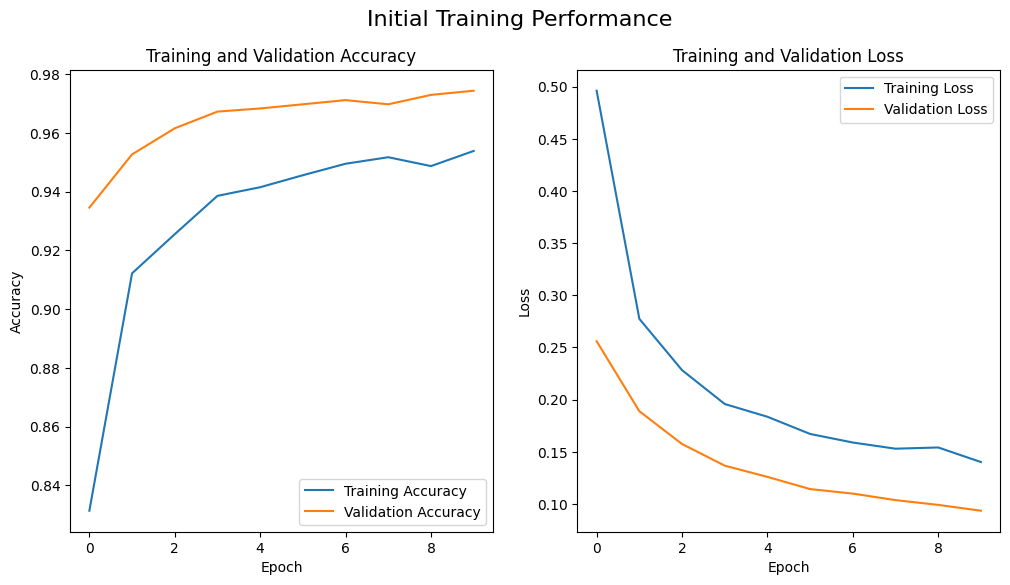

In [ ]:
import matplotlib.pyplot as plt

# --- Visualize Training History ---

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Create a figure with two subplots
plt.figure(figsize=(12, 6))
plt.suptitle('Initial Training Performance', fontsize=16)

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [ ]:
# --- Fine-Tuning ---

# First, let's unfreeze the base model
base_model.trainable = True

# Re-compile the model with a very low learning rate
# This is crucial to prevent destroying the pre-trained weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Use a much lower learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Continue training for 5 more epochs
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Resume training from where we left off
    validation_data=validation_dataset
)

Epoch 10/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 235s 537ms/step - accuracy: 0.7293 - loss: 0.7213 - val_accuracy: 0.8734 - val_loss: 0.3733
Epoch 11/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 193s 519ms/step - accuracy: 0.8774 - loss: 0.3282 - val_accuracy: 0.9179 - val_loss: 0.2601
Epoch 12/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 190s 486ms/step - accuracy: 0.9155 - loss: 0.2315 - val_accuracy: 0.9353 - val_loss: 0.2053
Epoch 13/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 215s 523ms/step - accuracy: 0.9354 - loss: 0.1819 - val_accuracy: 0.9459 - val_loss: 0.1609
Epoch 14/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 485ms/step - accuracy: 0.9436 - loss: 0.1603 - val_accuracy: 0.9584 - val_loss: 0.1262
Epoch 15/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 213s 518ms/step - accuracy: 0.9574 - loss: 0.1312 - val_accuracy: 0.9698 - val_loss: 0.0933


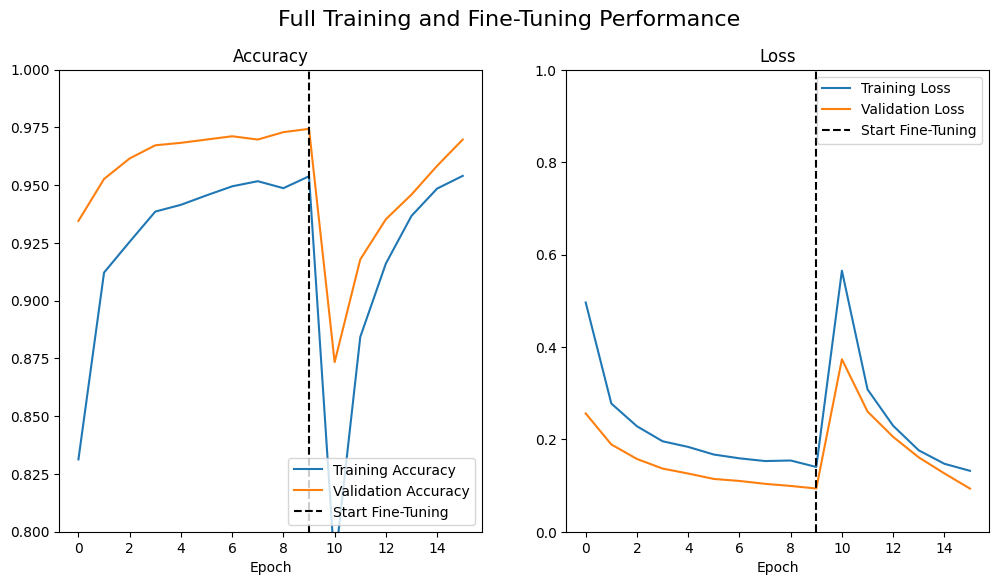

In [ ]:
import matplotlib.pyplot as plt

# --- Visualize the Entire Training Process ---

# Combine the history from the initial training and the fine-tuning phase
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

# Create a figure with two subplots
plt.figure(figsize=(12, 6))
plt.suptitle('Full Training and Fine-Tuning Performance', fontsize=16)

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
# Add a vertical line to show where fine-tuning started
plt.axvline(initial_epochs - 1, linestyle='--', color='k', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
# Add a vertical line to show where fine-tuning started
plt.axvline(initial_epochs - 1, linestyle='--', color='k', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

In [ ]:
# --- Save a copy in the legacy .h5 format ---

# Define the path and filename for the .h5 model
save_path_h5 = "/content/drive/MyDrive/MajorProject/Models/efficientnetv2b0_plastic.h5"

# Save the model
model.save(save_path_h5)

print(f"Model successfully saved in H5 format to: {save_path_h5}")

Model successfully saved in H5 format to: /content/drive/MyDrive/MajorProject/Models/efficientnetv2b0_plastic.h5


Model loaded successfully.


Saving PP-Plastic-5.png to PP-Plastic-5.png

--- Analyzing PP-Plastic-5.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


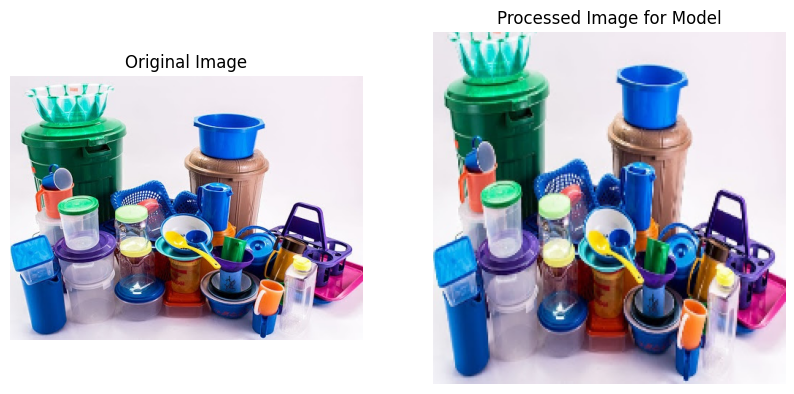

Prediction: PP with 77.14% confidence.


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- 1. Load your trained model ---
# Make sure the path to your saved .h5 model is correct
model_path = "/content/drive/MyDrive/MajorProject/Models/efficientnetv2b0_plastic.h5"
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")

# Define the class names in the correct order
class_names = ['HDPE', 'PET', 'PP', 'PS']

def preprocess_and_predict(image_path):
    """
    Applies a CV preprocessing pipeline to an image and predicts its class.
    """
    # --- CV Preprocessing Pipeline using OpenCV ---
    # Load the original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for display

    # 1. Isolate the object from the background
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Could not find any object in the image. Predicting on the original image.")
        # If no object is found, fallback to the original image
        processed_img = cv2.resize(img_rgb, (224, 224))
    else:
        # 2. Crop to the largest object found
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        # Add a small padding
        x, y, w, h = x - 10, y - 10, w + 20, h + 20
        x, y = max(0, x), max(0, y) # Ensure coordinates are not negative
        cropped_img = img_rgb[y:y+h, x:x+w]
        # 3. Prepare for model
        processed_img = cv2.resize(cropped_img, (224, 224))

    # --- TensorFlow Preprocessing and Prediction ---
    img_array = tf.keras.preprocessing.image.img_to_array(processed_img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    # --- Display Results ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title(f"Processed Image for Model")
    plt.axis("off")

    plt.show()
    print(f"Prediction: {predicted_class} with {confidence:.2f}% confidence.")


# --- 2. Upload your own image(s) to test ---
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n--- Analyzing {filename} ---")
    preprocess_and_predict(filename)

# ***XCEPTION***

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# --- 1. Setup Paths and Parameters ---
# The paths and parameters remain the same to ensure a fair comparison
BASE_DIR = "/root/.cache/kagglehub/datasets/aliefrahmanhakim/type-of-plastic-waste-dataset/versions/2"
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- 2. Create the Data Pipeline ---
# This is the same high-performance pipeline we created before
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get the class names
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Classes found:", class_names)

Found 11252 files belonging to 4 classes.
Found 2812 files belonging to 4 classes.
Classes found: ['HDPE', 'PET', 'PP', 'PS']


In [ ]:
# --- 3. Build the Xception Model (Corrected Version) ---

# We use the same data augmentation layer for consistency
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Load the pre-trained Xception model
base_model_xception = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model_xception.trainable = False

# --- IMPORTANT CHANGE IS HERE ---
# Create the full model by adding our custom head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
# Apply the correct preprocessing for Xception
x = tf.keras.applications.xception.preprocess_input(x)
# The rest of the model is the same
x = base_model_xception(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_xception = tf.keras.Model(inputs, outputs)

# Compile the model with the same settings as before
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print a summary of the new model's architecture
model_xception.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# --- 4. Initial Training ---

# We will train for the same number of epochs to ensure a fair comparison
initial_epochs_xception = 10

# The 'history_xception' object will store the performance metrics for each epoch
history_xception = model_xception.fit(
    train_dataset,
    epochs=initial_epochs_xception,
    validation_data=validation_dataset
)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 170s 471ms/step - accuracy: 0.7372 - loss: 0.6870 - val_accuracy: 0.9015 - val_loss: 0.3005
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 191s 440ms/step - accuracy: 0.8854 - loss: 0.3329 - val_accuracy: 0.9182 - val_loss: 0.2492
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 165s 468ms/step - accuracy: 0.9058 - loss: 0.2704 - val_accuracy: 0.9239 - val_loss: 0.2289
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 191s 436ms/step - accuracy: 0.9131 - loss: 0.2484 - val_accuracy: 0.9282 - val_loss: 0.2055
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 215s 473ms/step - accuracy: 0.9252 - loss: 0.2273 - val_accuracy: 0.9406 - val_loss: 0.1868
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 465ms/step - accuracy: 0.9292 - loss: 0.2150 - val_accuracy: 0.9349 - val_loss: 0.1879
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 193s 438ms/step - accuracy: 0.9339 - loss: 0.1986 - val_accuracy: 0.9413 - val_loss: 0.1725
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 212s 467ms/step - accuracy: 0.9381 -

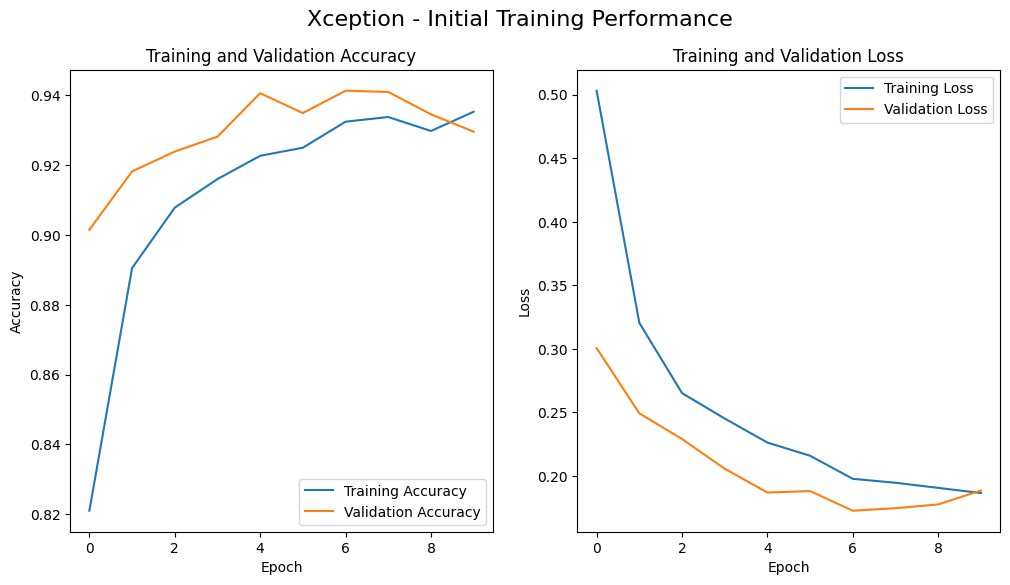

In [ ]:
# --- 5. Visualize Training History ---

# Extract accuracy and loss from the history object for Xception
acc_xception = history_xception.history['accuracy']
val_acc_xception = history_xception.history['val_accuracy']
loss_xception = history_xception.history['loss']
val_loss_xception = history_xception.history['val_loss']
epochs_range_xception = range(len(acc_xception))

# Create a figure with two subplots
plt.figure(figsize=(12, 6))
plt.suptitle('Xception - Initial Training Performance', fontsize=16)

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range_xception, acc_xception, label='Training Accuracy')
plt.plot(epochs_range_xception, val_acc_xception, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_xception, loss_xception, label='Training Loss')
plt.plot(epochs_range_xception, val_loss_xception, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [ ]:
# --- 6. Fine-Tuning ---

# Unfreeze the base model
base_model_xception.trainable = True

# Re-compile the model with a very low learning rate for fine-tuning
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Continue training for 5 more epochs
fine_tune_epochs_xception = 5
total_epochs_xception = initial_epochs_xception + fine_tune_epochs_xception

history_fine_tune_xception = model_xception.fit(
    train_dataset,
    epochs=total_epochs_xception,
    initial_epoch=history_xception.epoch[-1], # Resume from the last epoch
    validation_data=validation_dataset
)

Epoch 10/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 310s 792ms/step - accuracy: 0.8028 - loss: 0.5245 - val_accuracy: 0.9474 - val_loss: 0.1570
Epoch 11/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 302s 752ms/step - accuracy: 0.9304 - loss: 0.2064 - val_accuracy: 0.9673 - val_loss: 0.1037
Epoch 12/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 322s 753ms/step - accuracy: 0.9554 - loss: 0.1304 - val_accuracy: 0.9751 - val_loss: 0.0714
Epoch 13/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 276s 783ms/step - accuracy: 0.9675 - loss: 0.0934 - val_accuracy: 0.9762 - val_loss: 0.0597
Epoch 14/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 313s 756ms/step - accuracy: 0.9753 - loss: 0.0704 - val_accuracy: 0.9815 - val_loss: 0.0490
Epoch 15/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 321s 753ms/step - accuracy: 0.9853 - loss: 0.0462 - val_accuracy: 0.9876 - val_loss: 0.0364


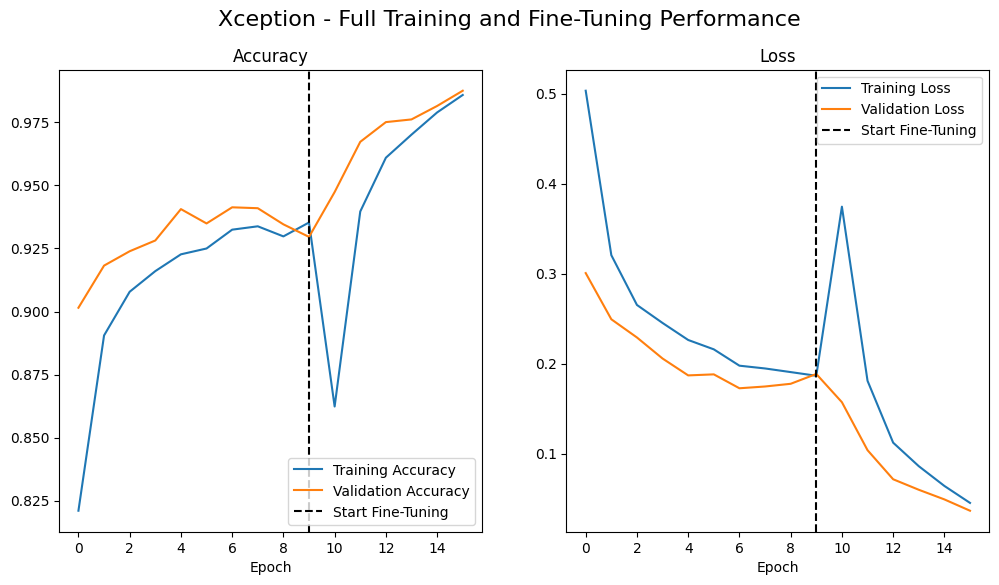

In [ ]:
# --- 7. Visualize the Entire Training Process ---

# Combine the history from both training phases
acc_full = history_xception.history['accuracy'] + history_fine_tune_xception.history['accuracy']
val_acc_full = history_xception.history['val_accuracy'] + history_fine_tune_xception.history['val_accuracy']
loss_full = history_xception.history['loss'] + history_fine_tune_xception.history['loss']
val_loss_full = history_xception.history['val_loss'] + history_fine_tune_xception.history['val_loss']

# Create the plots
plt.figure(figsize=(12, 6))
plt.suptitle('Xception - Full Training and Fine-Tuning Performance', fontsize=16)

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc_full, label='Training Accuracy')
plt.plot(val_acc_full, label='Validation Accuracy')
plt.axvline(initial_epochs_xception - 1, linestyle='--', color='k', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss_full, label='Training Loss')
plt.plot(val_loss_full, label='Validation Loss')
plt.axvline(initial_epochs_xception - 1, linestyle='--', color='k', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

In [ ]:
# --- 8. Save the Final Model in Both Formats ---

# Define the paths for both model formats
save_path_h5 = "/content/drive/MyDrive/MajorProject/Models/xception_plastic_classifier.h5"

# Save in the legacy .h5 format
model_xception.save(save_path_h5)
print(f"Model successfully saved in H5 format to: {save_path_h5}")

Model successfully saved in H5 format to: /content/drive/MyDrive/MajorProject/Models/xception_plastic_classifier.h5
